In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import torch
%matplotlib inline

In [2]:
np.set_printoptions(precision = 4, suppress = True)
torch.set_printoptions(sci_mode = False)

np.random.seed(0)
torch.manual_seed(0)

# Unary Linear Regression

In [3]:
def get_data():
    train_X = np.asarray([3.3,4.4,5.5,6.71,6.93,4.168,9.779,6.182,7.59,2.167,
                         7.042,10.791,5.313,7.997,5.654,9.27,3.1])
    train_Y = np.asarray([1.7,2.76,2.09,3.19,1.694,1.573,3.366,2.596,2.53,1.221,
                         2.827,3.465,1.65,2.904,2.42,2.94,1.3])
    x = torch.from_numpy(train_X).type(torch.FloatTensor).view(17,1)
    y = torch.from_numpy(train_Y).type(torch.FloatTensor)
    return x,y

def get_weights():
    w = torch.randn(1, requires_grad = True)
    b = torch.randn(1, requires_grad = True)
    return w,b

def simple_network(x):
    y_pred = torch.matmul(x,w) + b
    return y_pred

def loss_fn(y,y_pred):
    loss = (y_pred-y).pow(2).sum()
    for param in [w,b]:
        if not param.grad is None: param.grad.data.zero_()
    loss.backward()
    return loss.data.item()

def optimize(learning_rate):
    w.data -= learning_rate * w.grad.data
    b.data -= learning_rate * b.grad.data
    
learning_rate = 1e-3

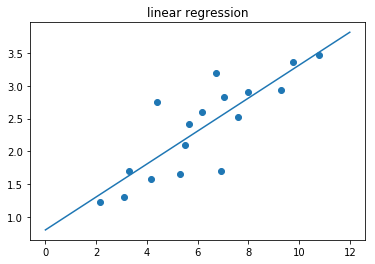

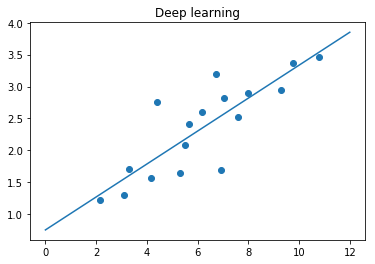

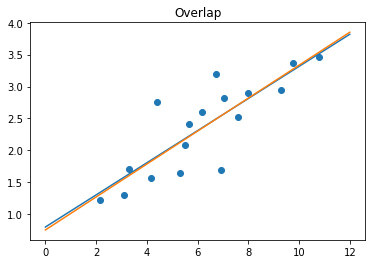

In [4]:
x,y = get_data()               # x - represents training data,y - represents target variables
xtick = np.linspace(0, 12, 1000)     # to draw a line

w0,b0 = np.polyfit(x.view(17).numpy(),y.numpy(),1)
plt.scatter(x.numpy(),y.numpy())
plt.plot(xtick, xtick*w0+b0)
plt.title('linear regression')
plt.show()

torch.manual_seed(0)
w,b = get_weights()           # w,b - Learnable parameters
for i in range(800):
    y_pred = simple_network(x) # function which computes wx + b
    loss = loss_fn(y,y_pred)   # calculates sum of the squared differences of y and y_pred
    optimize(learning_rate)    # Adjust w,b to minimize the loss
plt.scatter(x.numpy(),y.numpy())
plt.plot(xtick, xtick*w.item()+b.item())
plt.title('Deep learning')
plt.show()

plt.scatter(x.numpy(),y.numpy())
plt.plot(xtick, xtick*w0+b0)
plt.plot(xtick, xtick*w.item()+b.item())
plt.title('Overlap')
plt.show()

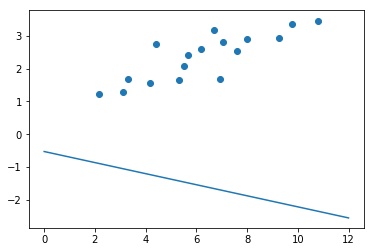

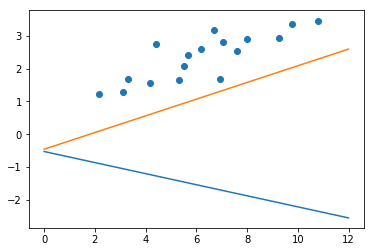

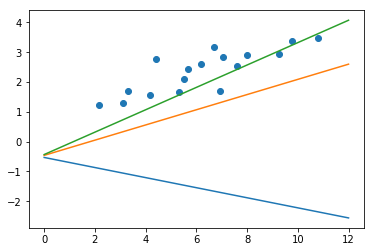

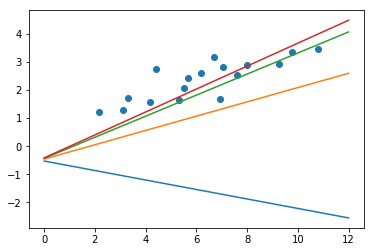

In [5]:
for j in range(2,10):
    if j % 2 == 0: 
        torch.manual_seed(0)
        x,y = get_data()              
        w,b = get_weights() 
        xtick = np.linspace(0, 12, 1000)     # to draw a line
        fig, axe = plt.subplots()
        axe.scatter(x.numpy(),y.numpy())
        for i in range(j):
            y_pred = simple_network(x) 
            loss = loss_fn(y,y_pred) 
            optimize(learning_rate)   
            if i % 2 == 0: 
                axe.plot(xtick, xtick*w.item()+b.item())


# 5 Features from Different Distributions

In [6]:
dataset_size, n_features = 1000000, 5
x1 = np.random.uniform(size = dataset_size)
x2 = np.random.normal(size = dataset_size)
x3 = np.random.beta(0.3, 0.7, size = dataset_size)
x4 = np.random.poisson(size = dataset_size)
x5 = np.random.weibull(0.45, size = dataset_size)
noise = np.random.normal(size = dataset_size)
ws, b = np.random.randn(n_features), np.random.randn(1)
x = np.array([x1, x2, x3, x4, x5]).transpose((1,0))
y = np.sum(x*ws, axis = 1) + b + noise

sm_model = sm.OLS(y, sm.add_constant(x)).fit()
# sm_model.summary()

x_tensor, y_tensor = torch.tensor(x).float(), torch.tensor(y).float()
nn_model = torch.nn.Linear(n_features, 1)
optimizer = torch.optim.SGD(nn_model.parameters(), lr = 0.01, momentum = 0.9)


for i in range(300): 
    optimizer.zero_grad()
    y_tensor_pred = nn_model(x_tensor).view(dataset_size)
    loss = torch.nn.MSELoss()(y_tensor_pred, y_tensor)
    loss.backward()
    optimizer.step()


print("Ground Truth     :", np.append(b, ws))
print("Linear Regression:", sm_model.params)
print("Neural Network   :", torch.cat([nn_model.bias.data, nn_model.weight.data.view(n_features)]).cpu().numpy())

Ground Truth     : [-0.5574  0.7379 -0.0784 -1.249   0.8517  0.2953]
Linear Regression: [-0.556   0.7334 -0.0797 -1.247   0.8528  0.2956]
Neural Network   : [-0.549   0.7228 -0.0797 -1.2495  0.8524  0.2955]


# Large number of Features

In [7]:
def main(dataset_size, n_features, lr, epochs):
    x = np.random.uniform(size = (dataset_size, n_features))
    noise = np.random.normal(size = dataset_size)
    ws, b = np.random.randn(n_features), np.random.randn(1)
    y = np.sum(x*ws, axis = 1) + b + noise

    sm_model = sm.OLS(y, sm.add_constant(x)).fit()

    x_tensor, y_tensor = torch.tensor(x).float(), torch.tensor(y).float()
    nn_model = torch.nn.Linear(n_features, 1)
    optimizer = torch.optim.SGD(nn_model.parameters(), lr, momentum = 0.7)

    for i in range(epochs): 
        optimizer.zero_grad()
        y_tensor_pred = nn_model(x_tensor).view(dataset_size)
        loss = torch.nn.MSELoss()(y_tensor_pred, y_tensor)
        loss.backward()
        optimizer.step()
    nn_params = torch.cat([nn_model.bias.data, nn_model.weight.data.view(n_features)]).cpu().numpy()

    print("Linear Regression:", np.mean(np.abs(np.append(b, ws) - sm_model.params)))
    print("Neural Network   :", np.mean(np.abs(np.append(b, ws) - nn_params)))

In [8]:
main(3000, 100, 0.01, 1000)

Linear Regression: 0.06068632690903055
Neural Network   : 0.06129101542393538


In [9]:
main(3000, 1000, 0.003, 3000)

Linear Regression: 0.0631968014477706
Neural Network   : 0.10067417383854552


In [10]:
main(3000, 3000, 0.0003, 30000)

Linear Regression: 1.53836348673081
Neural Network   : 0.3504564941425056
